In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibm_lagos'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

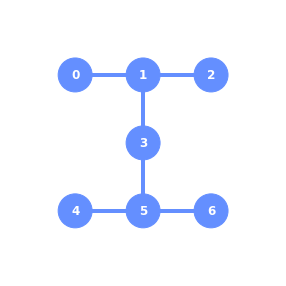

In [3]:
qubits = plot_gate_map(backend)
qubits

In [4]:
def extract_cr_params(cx_sched):
    cr_params = {}
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], ControlChannel):
                    cr_params["duration"] = inst.pulse.duration
                    cr_params["width"] = inst.pulse.width
                    cr_params["sigma"] = inst.pulse.sigma
                    cr_params["cr_amp"] = inst.pulse.amp
                    cr_params["channel"] = inst.channel
    return cr_params
                    

def build_cr_schedule(backend, qc, qt, cr_params, cr_name):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
            name=cr_name
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])
#     cr_circuit.x(0)
#     cr_circuit.append(gate, [0, 1])
#     cr_circuit.x(0)
    
    return cr_circuit

def build_experiment_circuits(backend, qc, qt, amps, cr_params, rotary=False):
    
    circ_list = []
    
    inst_map_list = []
    for amplitude in amps:
        
        new_inst_map = deepcopy(inst_map)
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[-amplitude],
        )

        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[amplitude],
        )
        exp_circ = QuantumCircuit(2)

        ## add control state prep when needed

        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }

        if rotary is True:
            cr_params['cancel_amp'] = amplitude
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))
        
        cr_params['phi'] = cr_params['phi'] + np.pi
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
#         new_inst_map.add('cr_gate', qubits=[qc, qt], schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
    return circ_list, inst_map_list

def expectation_val(count_dict, mem_ind):

    expv = 0
    for key, val in count_dict.items():
        if key[::-1][mem_ind] == '1':
            expv -= val
        else:
            expv += val

    return expv / sum(count_dict.values())

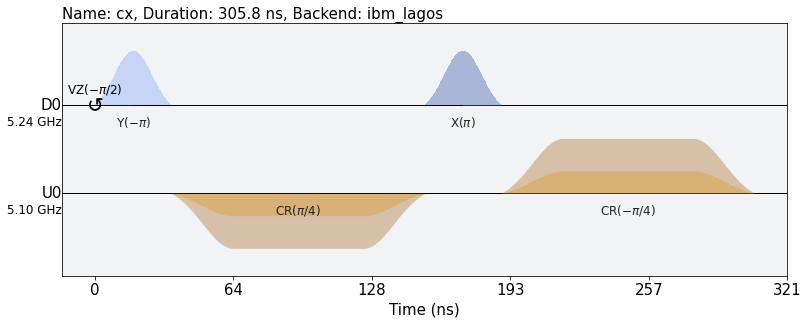

In [5]:
q1, q2 = 0, 1
mem_ind = 0 if q1 > q2 else 1

cx_sched = inst_map.get('cx', qubits=[q1, q2])
draw(cx_sched, backend=backend, disable_channels=[DriveChannel(q2)])

In [6]:
for time, inst in cx_sched.instructions:
    print(inst)

ShiftPhase(1.5707963267948966, DriveChannel(0))
ShiftPhase(1.5707963267948966, ControlChannel(1))
Play(Drag(duration=160, amp=(-3.5212648507813324e-17-0.1916887303470124j), sigma=40, beta=-1.1242428995416691, name='Ym_d0'), DriveChannel(0), name='Ym_d0')
Play(Drag(duration=160, amp=(0.09713074233616353+0.0008228977991439125j), sigma=40, beta=-1.3255320808814979, name='X90p_d1'), DriveChannel(1), name='X90p_d1')
Play(GaussianSquare(duration=528, amp=(0.05953343840015568+0.0004353277943512729j), sigma=64, width=272, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')
Play(GaussianSquare(duration=528, amp=(-0.24759486547846224-0.6082109911315869j), sigma=64, width=272, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')
Play(Drag(duration=160, amp=(0.1916887303470124+0j), sigma=40, beta=-1.1242428995416691, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Play(GaussianSquare(duration=528, amp=(-0.05953343840015568-0.00043532779435126565j), sigma=64, width=272, name='CR90m_d1_u0'), Dr

In [22]:
cr_params = extract_cr_params(cx_sched)
cr_params["cancel_amp"] = 0.0
cr_params["phi"] = 0
# print(cr_params)

max_cr_amplitude = 0.35
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)
print(cr_amps)

[-0.35       -0.31315789 -0.27631579 -0.23947368 -0.20263158 -0.16578947
 -0.12894737 -0.09210526 -0.05526316 -0.01842105  0.01842105  0.05526316
  0.09210526  0.12894737  0.16578947  0.20263158  0.23947368  0.27631579
  0.31315789  0.35      ]


In [7]:
exp_circuits, exp_inst_maps = build_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
print(len(exp_circuits))
exp_circuits[10].draw()

{'duration': 528, 'width': 272, 'sigma': 64, 'cr_amp': (0.24759486547846232+0.6082109911315869j), 'channel': ControlChannel(0), 'cancel_amp': 0.0, 'phi': 0}
20


┌──────────────────────┐┌───┐┌───────────────────────┐┌───┐ ░ ┌─┐   
      q_0: ┤0                     ├┤ X ├┤0                      ├┤ X ├─░─┤M├───
           │  cr_p_gate(0.013158) │└───┘│  cr_m_gate(-0.013158) │└───┘ ░ └╥┘┌─┐
      q_1: ┤1                     ├─────┤1                      ├──────░──╫─┤M├
           └──────────────────────┘     └───────────────────────┘      ░  ║ └╥┘
measure: 2/═══════════════════════════════════════════════════════════════╩══╩═
                                                                          0  1

In [8]:
tc = transpile(exp_circuits, backend, initial_layout=[q1, q2])
sched = schedule(tc, backend)
for time, inst in sched[5].instructions:
    print(inst)

Delay(528, DriveChannel(0))
Delay(528, DriveChannel(1))
Play(GaussianSquare(duration=528, amp=(0.11842105263157895+7.251198152846171e-17j), sigma=64, width=272, name='cr_p'), ControlChannel(0), name='cr_p')
Play(Drag(duration=160, amp=(0.1916887303470124+0j), sigma=40, beta=-1.1242428995416691, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(528, DriveChannel(0))
Delay(528, DriveChannel(1))
Play(GaussianSquare(duration=528, amp=(-0.11842105263157895-8.701437783415404e-17j), sigma=64, width=272, name='cr_m'), ControlChannel(0), name='cr_m')
Play(Drag(duration=160, amp=(0.1916887303470124+0j), sigma=40, beta=-1.1242428995416691, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Acquire(1792, AcquireChannel(0), MemorySlot(0))
Acquire(1792, AcquireChannel(1), MemorySlot(1))
Play(GaussianSquare(duration=1792, amp=(-0.23229046577561074+0.11679528890220625j), sigma=64, width=1536, name='M_m0'), MeasureChannel(0), name='M_m0')
Play(GaussianSquare(duration=1792, amp=(0.11801154122593771-0.32227

In [9]:
tc[4].draw()

┌──────────────────────┐┌───┐┌─────────────────────┐┌───┐ ░ ┌─┐»
      q_0 -> 0 ┤0                     ├┤ X ├┤0                    ├┤ X ├─░─┤M├»
               │  cr_p_gate(-0.14474) │└───┘│  cr_m_gate(0.14474) │└───┘ ░ └╥┘»
      q_1 -> 1 ┤1                     ├─────┤1                    ├──────░──╫─»
               └──────────────────────┘     └─────────────────────┘      ░  ║ »
ancilla_0 -> 2 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_1 -> 3 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_2 -> 4 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_3 -> 5 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
ancilla_4 -> 6 ─────────────────────────────────────────────────────────────╫─»
                                                                            ║ »
    measure: 2/═════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«                  
«      q_0 -> 0 ───
«               ┌─┐
«      q_1 -> 1 ┤M├
«               └╥┘
«ancilla_0 -> 2 ─╫─
«                ║ 
«ancilla_1 -> 3 ─╫─
«                ║ 
«ancilla_2 -> 4 ─╫─
«                ║ 
«ancilla_3 -> 5 ─╫─
«                ║ 
«ancilla_4 -> 6 ─╫─
«                ║ 
«    measure: 2/═╩═
«                1

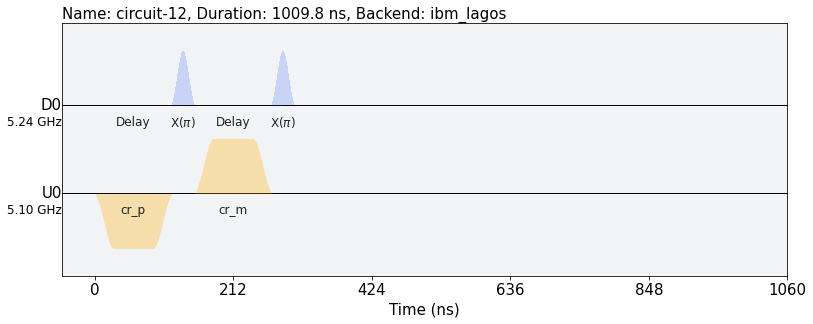

In [10]:
draw(sched[4], backend=backend, disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [23]:
i = 1
identifier = F"({q1},{q2})"

In [24]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

6188ce32b3f490630660bcab


In [25]:
results = backend.retrieve_job(job_id).result()
i+=1

In [26]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 1643, '01': 30, '10': 372, '11': 3}, {'00': 1678, '01': 31, '10': 335, '11': 4}, {'00': 1776, '01': 59, '10': 210, '11': 3}, {'00': 1772, '01': 41, '10': 233, '11': 2}, {'00': 1862, '01': 48, '10': 136, '11': 2}, {'00': 1852, '01': 68, '10': 125, '11': 3}, {'00': 1925, '01': 53, '10': 68, '11': 2}, {'00': 1932, '01': 60, '10': 56}, {'00': 1971, '01': 63, '10': 14}, {'00': 1964, '01': 60, '10': 23, '11': 1}, {'00': 1977, '01': 54, '10': 17}, {'00': 1971, '01': 53, '10': 24}, {'00': 1944, '01': 57, '10': 44, '11': 3}, {'00': 1923, '01': 45, '10': 78, '11': 2}, {'00': 1875, '01': 55, '10': 115, '11': 3}, {'00': 1832, '01': 56, '10': 158, '11': 2}, {'00': 1769, '01': 52, '10': 225, '11': 2}, {'00': 1723, '01': 50, '10': 273, '11': 2}, {'00': 1664, '01': 38, '10': 342, '11': 4}, {'00': 1648, '01': 33, '10': 358, '11': 9}]


In [27]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [31]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(count_dict[cind], mem_ind=mem_ind)
print(exp_z)   
valid_inds = np.where(np.abs(cr_amps) < 0.35)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

[0.63378906 0.66894531 0.79199219 0.77050781 0.86523438 0.875
 0.93164062 0.9453125  0.98632812 0.9765625  0.98339844 0.9765625
 0.95410156 0.921875   0.88476562 0.84375    0.77832031 0.73144531
 0.66210938 0.64160156]


In [32]:
print(cr_pi2_amp)

0.5517617705494882


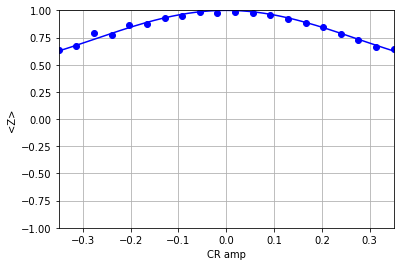

In [33]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()